In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import sklearn.preprocessing as sk
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/jobathon/train_s3TEQDk.csv")
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


#EDA

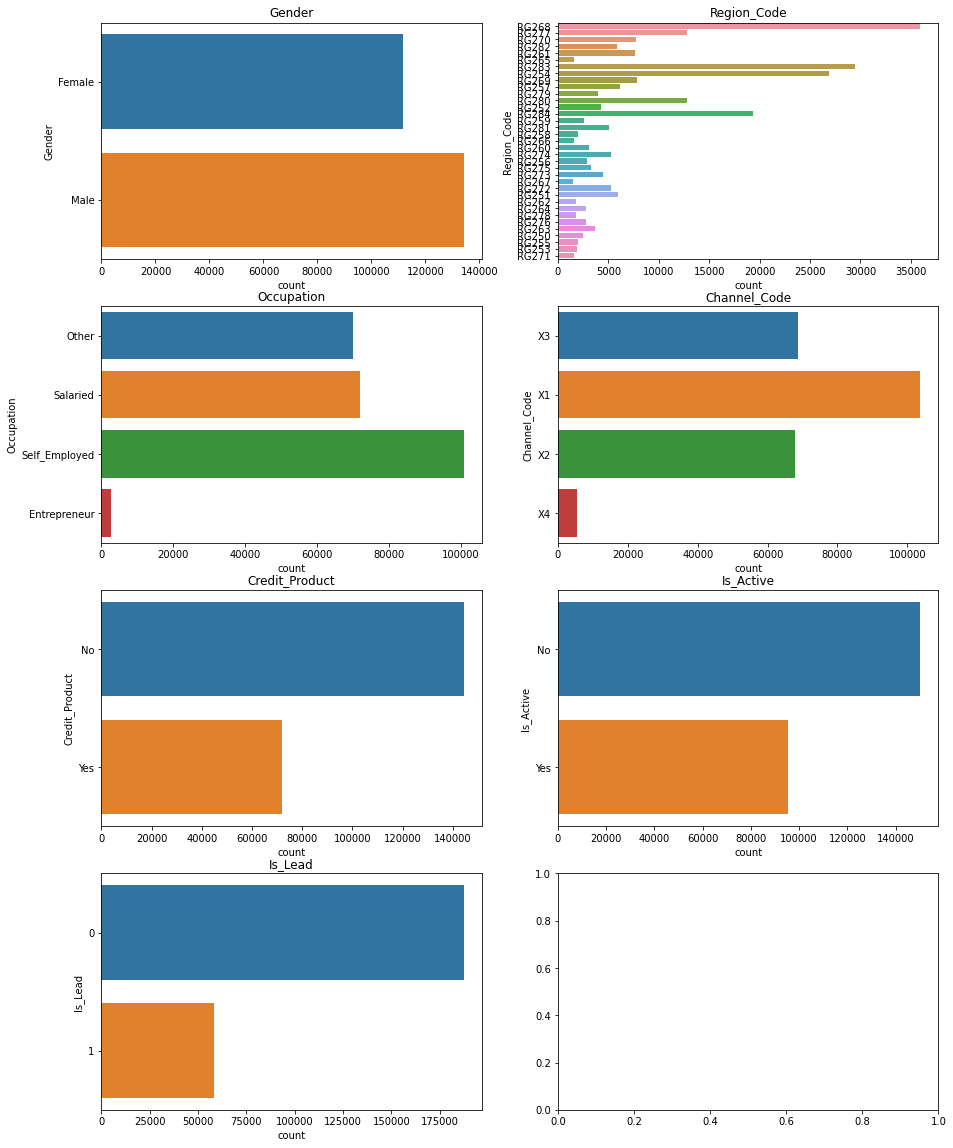

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = ax.flatten()
i=0
for col in categorical:
    sns.countplot(y=df[col],ax=ax[i])
    ax[i].set_title(col)
    i+=1
plt.show()

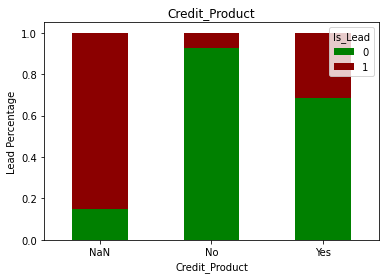

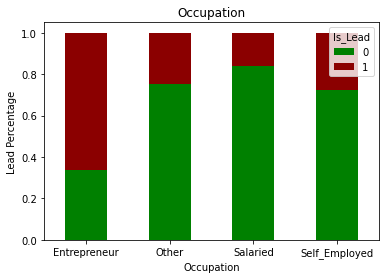

In [ ]:
def stacked_plot(df, group, target):
    fig, ax = plt.subplots(figsize = (6,4))
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='bar', stacked=True, ax = ax, color = ["green", "darkred"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Lead Percentage')
    ax.set_title(group)
    return ax

stacked_plot(df, 'Credit_Product', 'Is_Lead')
stacked_plot(df, 'Occupation', 'Is_Lead')

From below cell, if customer have credit product, he/she is more likely to get credit card

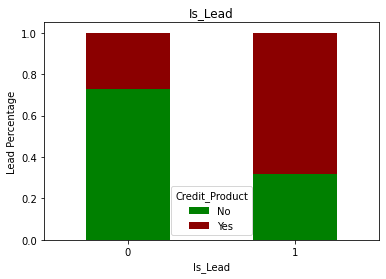

In [ ]:
stacked_plot(df, 'Is_Lead', 'Credit_Product')

In [ ]:
CP_nan[CP_nan['Is_Lead']==1].shape[0]/CP_nan.shape[0]

0.8516624040920716

In missing **Credit_Product** information, 85%  of the people are interested in credit card(Is_Lead == 1).
This must be handled!!

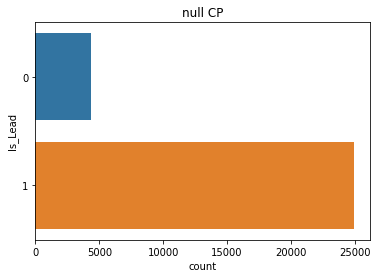

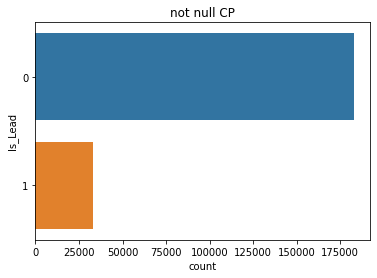

In [ ]:
CP_nan = df[df.Credit_Product.isna()].reset_index()
CP_notna = df[df.Credit_Product.notna()].reset_index()
sns.countplot(y=CP_nan['Is_Lead'])
plt.title('null CP')
plt.show()
sns.countplot(y=CP_notna['Is_Lead'])
plt.title('not null CP')
plt.show()

###Correlation and pairplot

No inference from pairplot -> no relation captured 

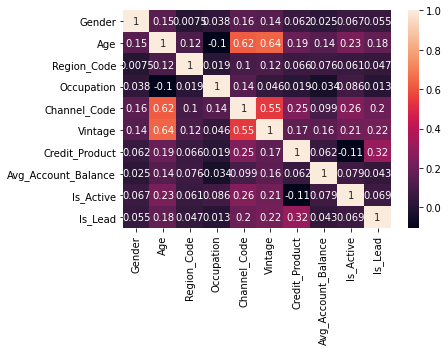

In [ ]:
corr = df_encoded.corr()
fig = plt.Figure(figsize = (10,10))
sns.heatmap(corr,annot=True,)
plt.show()

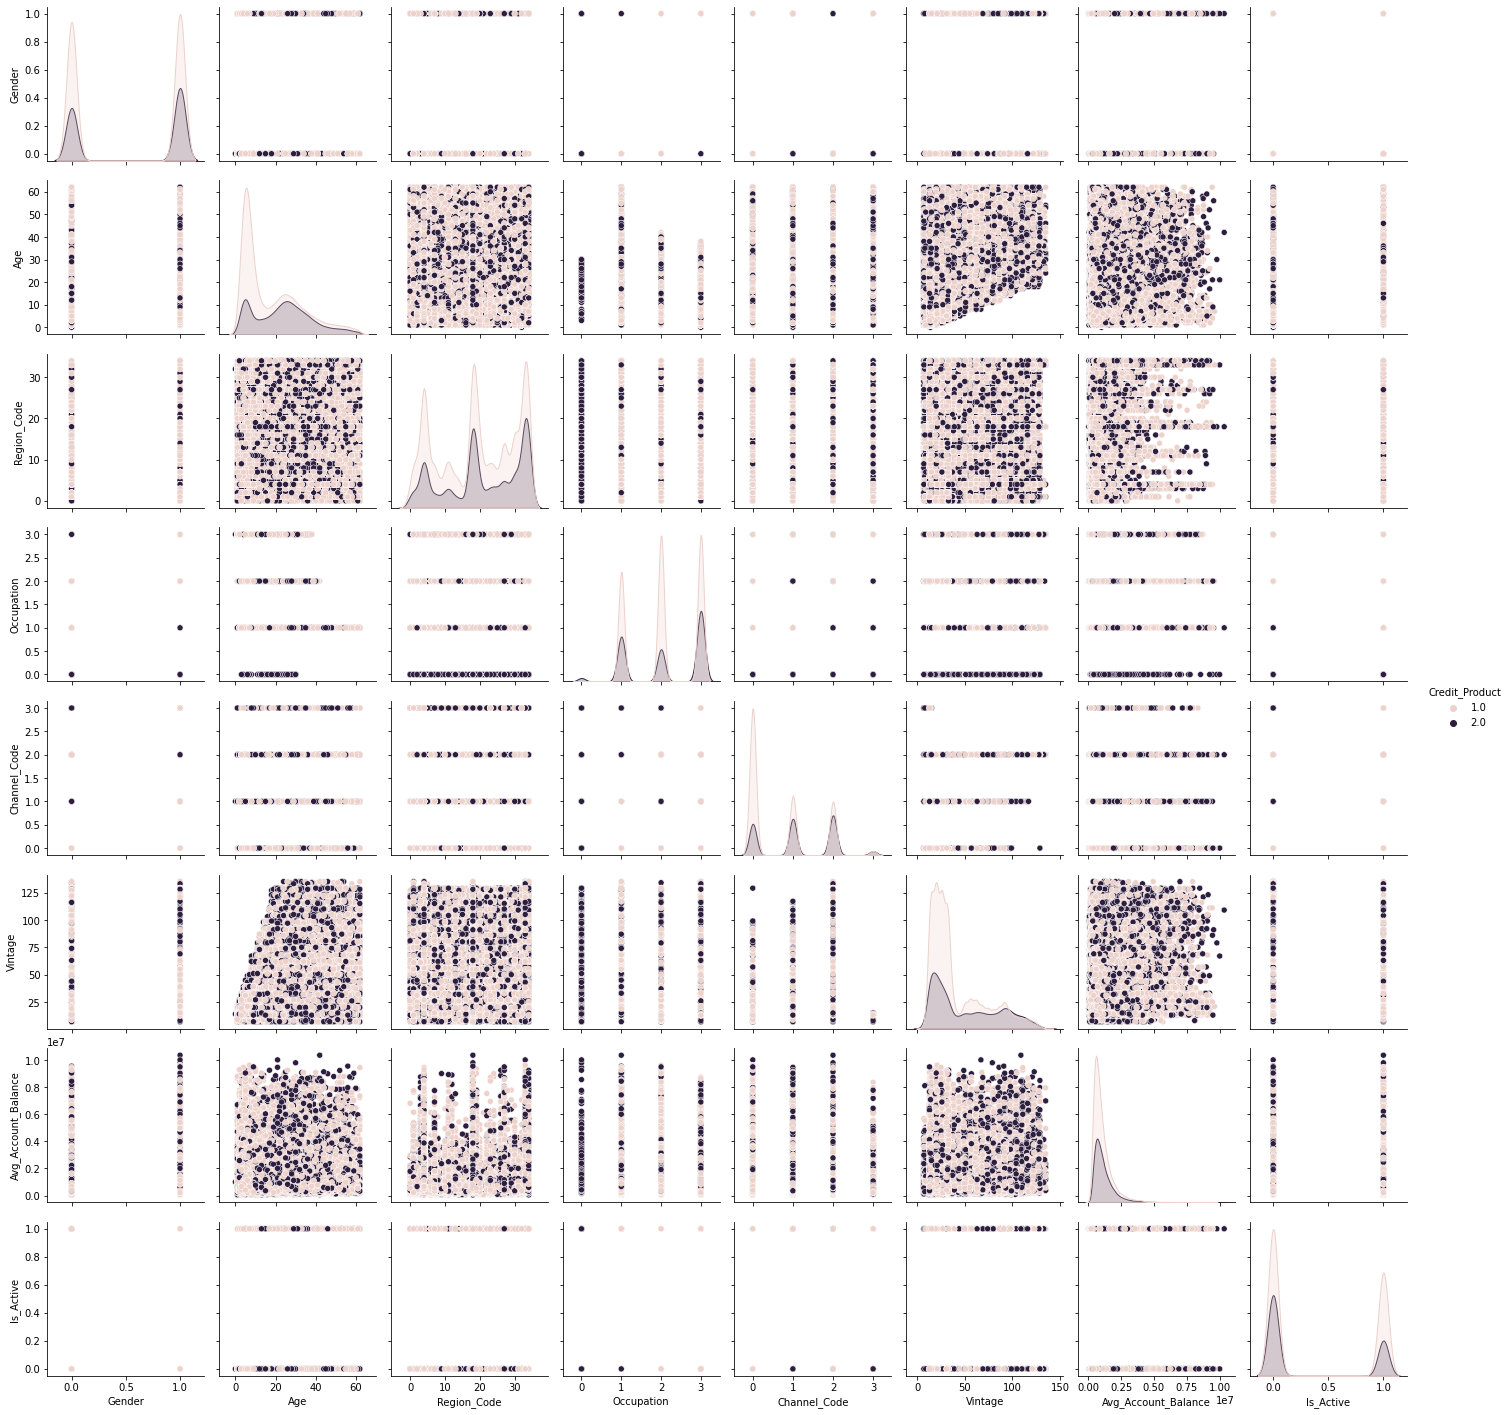

In [ ]:
sns.pairplot(df_encoded[df.columns[1:-1]],hue = 'Credit_Product')

##Encode functions

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
categorical = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Is_Lead']

def encode_train(df):
    df['Credit_Product'][pd.isnull(df.Credit_Product)] = 'NaN'
    encoder_dict = defaultdict(sk.LabelEncoder)
    df_encoded = df.copy()
    df_encoded[categorical[:-1]] = df[categorical[:-1]].apply(lambda x: encoder_dict[x.name].fit_transform(x))
    df_encoded['Credit_Product'][df_encoded.Credit_Product==0]  = np.nan
    scaler = sk.RobustScaler()
    # df_encoded[['Age', 'Avg_Account_Balance', 'Vintage']] = scaler.fit_transform(df_encoded[['Age', 'Avg_Account_Balance', 'Vintage']])
    return df_encoded, encoder_dict, scaler

def encode_test(df, encoder_dict, scaler):
    df['Credit_Product'][pd.isnull(df.Credit_Product)] = 'NaN'
    df_encoded = df.copy()
    df_encoded[categorical[:-1]] = df[categorical[:-1]].apply(lambda x: encoder_dict[x.name].transform(x))
    df_encoded['Credit_Product'][df_encoded.Credit_Product==0]  = np.nan
    # df_encoded[['Age', 'Avg_Account_Balance', 'Vintage']] = scaler.transform(df_encoded[['Age', 'Avg_Account_Balance', 'Vintage']])
    return df_encoded

def iterImputer(df):
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp.fit(df[df.columns[1:-1]])
    imputed = np.round(imp.transform(df[df.columns[1:-1]]))
    df_imputed = df.copy()
    df_imputed[df.columns[1:-1]] = pd.DataFrame(imputed, columns=[df.columns[1:-1]])
    return df_imputed, imp

def iterImputer_test(df,imputer):
    df_imputed = df.copy()
    df_imputed[df.columns[1:]] = pd.DataFrame(np.round(imputer.transform(df[df.columns[1:]])), columns=[df.columns[1:]])
    return df_imputed

def knnimputer(df):
    imputer = KNNImputer(weights='distance')
    imputed = imputer.fit_transform(df[df.columns[1:-1]])
    df_imputed = df.copy()
    df_imputed[df.columns[1:-1]] = pd.DataFrame(np.round(imputed), columns=[df.columns[1:-1]])
    return df_imputed, imputer

def knnimputer_test(df,imputer):
    df_imputed = df.copy()
    df_imputed[df.columns[1:]] = pd.DataFrame(np.round(imputer.transform(df[df.columns[1:]])), columns=[df.columns[1:]])
    return df_imputed

def to_category(df):
    df['Age_Band'] =  pd.qcut(df.Age, q=4)
    df['AC_Band'] =  pd.qcut(df.Avg_Account_Balance, q=4)
    df['Vintage_Band'] =  pd.qcut(df.Vintage, q=4)

    df.Age = pd.qcut(df.Age, q=4 ,labels=[0,1,2,3])
    df.Avg_Account_Balance = pd.qcut(df.Avg_Account_Balance, q=4 ,labels=[0,1,2,3])
    df.Vintage = pd.qcut(df.Vintage, q=4 ,labels=[0,1,2,3])
    return df

def LR_imputer(train_x, train_y, test_x):
    logreg = LogisticRegression()
    logreg.fit(train_x, train_y)
    Y_pred = logreg.predict(test_x)


encoded and Iterative_imputer

In [ ]:
df_encoded, encoder, scaler = encode_train(df)
df_imputed, imputer = iterImputer(df_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_imputed.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0.0,73.0,18.0,1.0,2.0,43.0,1.0,1045696.0,0.0,0
1,IDD62UNG,0.0,30.0,27.0,2.0,0.0,32.0,1.0,581988.0,0.0,0
2,HD3DSEMC,0.0,56.0,18.0,3.0,2.0,26.0,1.0,1484315.0,1.0,0
3,BF3NC7KV,1.0,34.0,20.0,2.0,0.0,19.0,1.0,470454.0,0.0,0
4,TEASRWXV,0.0,30.0,32.0,2.0,0.0,33.0,1.0,886787.0,0.0,0


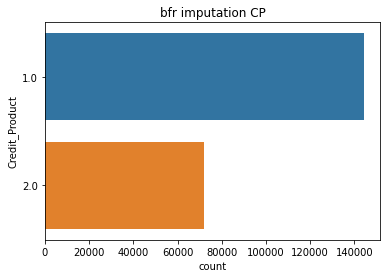

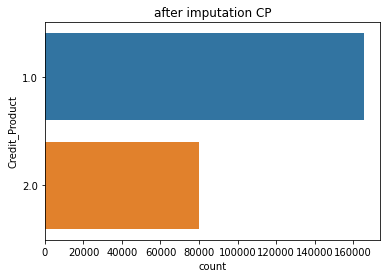

Text(0.5, 1.0, 'Before imputation\\mIs_Lead')

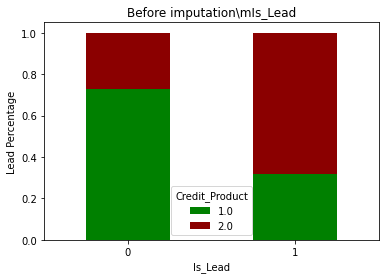

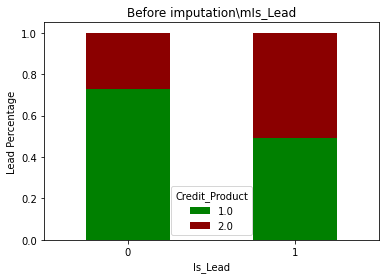

In [ ]:
sns.countplot(y=df_encoded['Credit_Product'])
plt.title('bfr imputation CP')
plt.show()

sns.countplot(y=df_imputed['Credit_Product'])
plt.title('after imputation CP')
plt.show()

ax=stacked_plot(df_encoded, 'Is_Lead', 'Credit_Product')
ax.set_title('Before imputation\mIs_Lead')
ax=stacked_plot(df_imputed, 'Is_Lead', 'Credit_Product')
ax.set_title('Before imputation\mIs_Lead')

In [ ]:
encoder['Credit_Product'].inverse_transform([1,2])

array(['No', 'Yes'], dtype=object)

In [ ]:
df_encoded.to_csv('/content/drive/MyDrive/jobathon/encoded_data.csv',index=False)
df_imputed.to_csv('/content/drive/MyDrive/jobathon/process_data.csv',index=False)

#train test split

In [ ]:
train, test = train_test_split(df_imputed, test_size=0.2, random_state=111, stratify = df.Is_Lead)
x = df_imputed.columns[1:]
y = "Is_Lead"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]


#Testing

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/jobathon/test_mSzZ8RL.csv")

test_encoded = encode_test(test_df,encoder,scaler)
test_imputed = iterImputer_test(test_encoded,imputer)
test_imputed.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1.0,29.0,4.0,1.0,0.0,25.0,2.0,742366.0,0.0
1,CCMEWNKY,1.0,43.0,18.0,1.0,1.0,49.0,1.0,925537.0,0.0
2,VK3KGA9M,1.0,31.0,20.0,2.0,0.0,14.0,1.0,215949.0,0.0
3,TT8RPZVC,1.0,29.0,22.0,1.0,0.0,33.0,1.0,868070.0,0.0
4,SHQZEYTZ,0.0,29.0,20.0,1.0,0.0,19.0,1.0,657087.0,0.0


In [ ]:
test_imputed.to_csv("/content/drive/MyDrive/jobathon/pro_test.csv",index=False)
test_encoded.to_csv("/content/drive/MyDrive/jobathon/encoded_test.csv",index=False)
